In [7]:
import os
import io
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import theano
import matplotlib.pyplot as plt
from sklearn import preprocessing
from time import time
from sklearn.metrics import *
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.ensemble import GradientBoostingClassifier as gbm
from IPython.display import Image

%matplotlib inline

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [118]:
from sklearn.manifold import TSNE
from time import clock
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.base import TransformerMixin, BaseEstimator
import scipy.sparse as sps
from scipy.linalg import pinv
import sys

In [127]:
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

In [163]:
import itertools
from scipy import linalg
import matplotlib as mpl

### Loading data set

In [11]:
names = """Wine_Class, Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline"""

In [12]:
col_names = names.split(', ')

In [20]:
# download the file from UCI Machine learning repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"   
s = requests.get(url).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')), names = col_names, header = None)

In [16]:
data.head()

,Wine_Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Wine_Class                      178 non-null int64
Alcohol                         178 non-null float64
Malic acid                      178 non-null float64
Ash                             178 non-null float64
Alcalinity of ash               178 non-null float64
Magnesium                       178 non-null int64
Total phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Nonflavanoid phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
Color intensity                 178 non-null float64
Hue                             178 non-null float64
OD280/OD315 of diluted wines    178 non-null float64
Proline                         178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


In [21]:
X = data.drop('Wine_Class',1).copy().values
Y = data['Wine_Class'].copy().values

### Preprocessing the data

In [116]:
transformedX = StandardScaler().fit_transform(X)

In [60]:
def cluster_acc(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return accuracy_score(Y, pred)

### K-Means

In [272]:
distortions = []
K = range(2,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(transformedX)
#     kmeanModel.fit(transformedX)
    labels = kmeanModel.labels_
    distortions.append(sum(np.min(cdist(transformedX, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
#     metrics.calinski_harabaz_score(X, labels)  

Why Euclidean distance for KMeans?? - https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric
Answer with 27 votes    

### Finding optimal 'K'

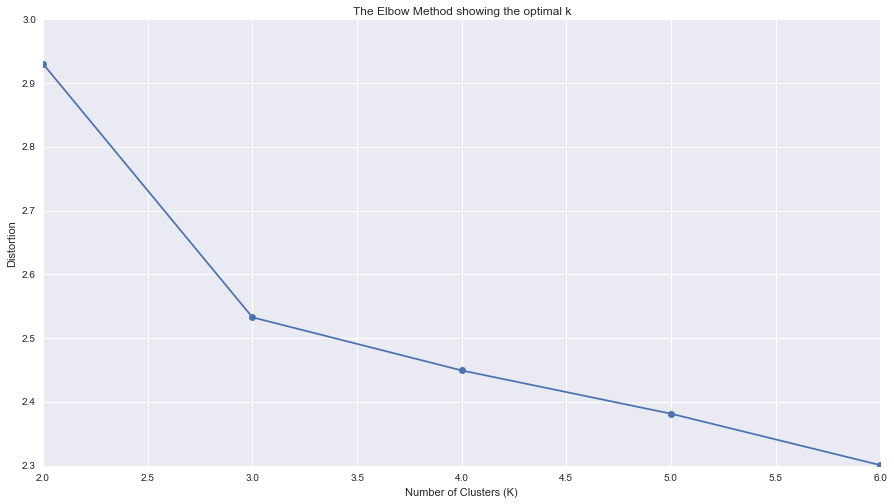

In [273]:
# Plot the elbow
plt.figure(figsize = (15,8))
plt.plot(K, distortions, marker = 'o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('Elbow_plot_exp1.png')

Here for this experiment, I have used elbow method to find the optimal 'K' value (K = 3). The 'K' value at the elbow like point. Other way to find the optimal 'K' is to use silhoutte score, due to time constraint I have not cross validated to see if the 'K' value obtained using this method is same as the Elbow method.

### Expectation Maximization - Gausian Mixture Models

In [153]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GMM(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(transformedX)
        bic.append(gmm.bic(transformedX))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

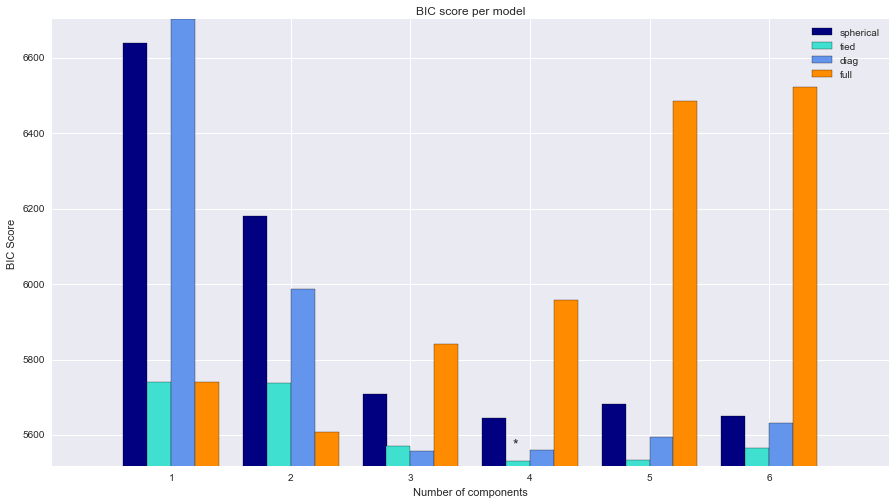

In [176]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.figure(figsize = (15,8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.ylabel('BIC Score')
plt.legend([b[0] for b in bars], cv_types)
plt.savefig('BIC_plot_exp1.png')

In [172]:
best_gmm

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

For EM model, I have choosen BIC (Bayesian Information Criterion) to determine the optimal K and covariance type. (K = 4) with covariance_type = 'tied' has the minimum BIC Score. We can also use AIC (Akaike Information Criterion) for this purpose due to time constraint I have not calculated AIC.

For detail description please refer: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

### PCA

In [182]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from helpers import  nn_arch,nn_reg
from matplotlib import cm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [189]:
X.shape

(178, 13)

In [191]:
data = pca.explained_variance_

In [203]:
pca1 = PCA(random_state=5)
pca1.fit(transformedX)
#The amount of variance that each PC explains
var= pca1.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)

In [204]:
var1

array([  36.2 ,   55.41,   66.53,   73.6 ,   80.16,   85.1 ,   89.34,
         92.02,   94.24,   96.17,   97.91,   99.21,  100.01])

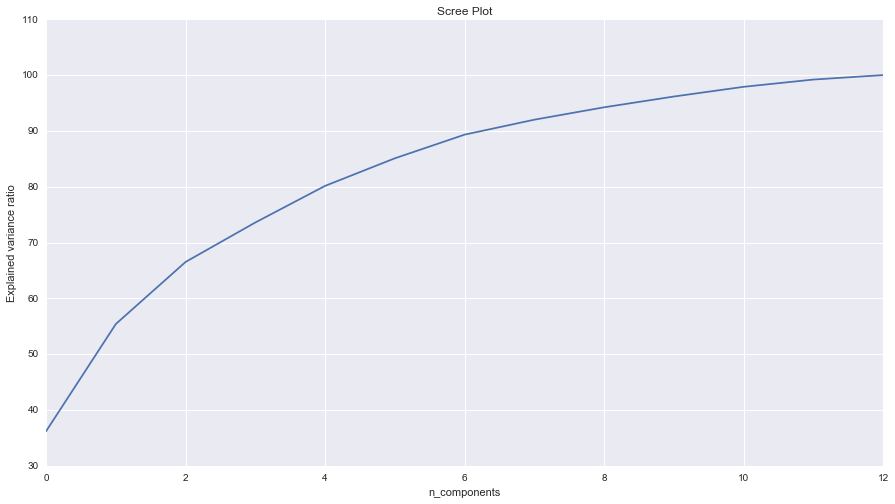

In [205]:
plt.figure(figsize = (15,8))
plt.plot(var1)
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('Scree Plot')
plt.savefig('screeplot_exp1.png')

In [200]:
var1

array([  36.2 ,   55.41,   66.53,   73.6 ,   80.16,   85.1 ,   89.34,
         92.02,   94.24,   96.17,   97.91,   99.21,  100.01])

From above, majority of the variance is explained at n_components = 12; <<"""Talk about scree plot, how to choose n_components and on what basis?""">>

### ICA

In [206]:
from sklearn.decomposition import FastICA

In [190]:
dims = [2,3,5,7,9,10,11,13]

In [277]:
ica = FastICA(random_state=5)
kurt = {}
for dim in dims:
    ica.set_params(n_components=dim, random_state = 5)
    tmp = ica.fit_transform(transformedX)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()
kurt = pd.Series(kurt) 

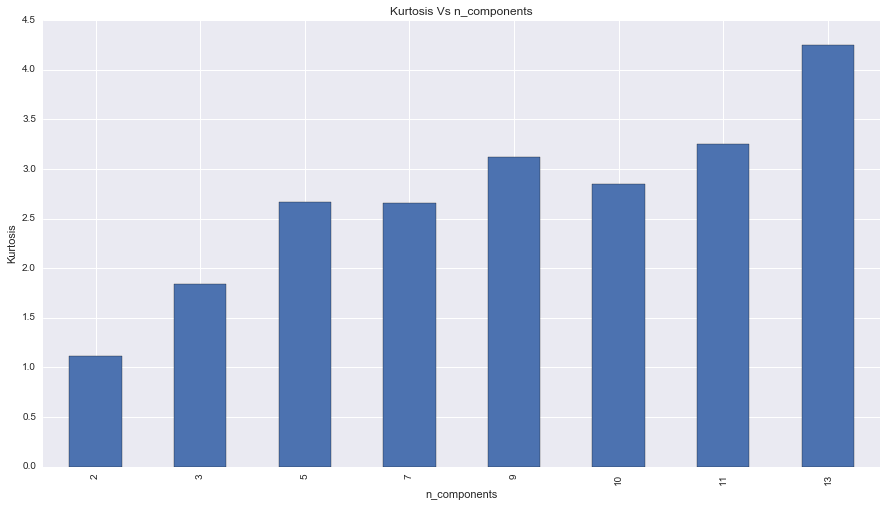

In [278]:
plt.figure(figsize = (15, 8))
kurt.plot(kind = 'bar')
plt.xlabel('n_components')
plt.ylabel('Kurtosis')
plt.title('Kurtosis Vs n_components')
plt.savefig('ica_exp1.png')

Refer https://github.com/anu003/CS7641-Machine-Learning/blob/master/Assignment3/ycai87-analysis.pdf

Kurtosis is highest at n_components = 13

### Random Projections

In [214]:
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from itertools import product

In [215]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') 

In [244]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

In [254]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p*W)*(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [260]:
# rp = None
# tmp = defaultdict(dict)
# for i,dim in product(range(10),dims):
#     rp = SparseRandomProjection(random_state=i, n_components=dim)
#     tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(transformedX), transformedX)
# tmp = pd.DataFrame(tmp).T

In [262]:
# tmp

In [255]:
# tmp = defaultdict(dict)
# for i,dim in product(range(10),dims):
#     rp = SparseRandomProjection(random_state=i, n_components=dim)
#     rp.fit(transformedX)    
#     tmp[dim][i] = reconstructionError(rp, transformedX)
# tmp =pd.DataFrame(tmp).T
# # tmp.to_csv(out+'madelon scree2.csv')

In [263]:
# tmp

In [266]:
# rp = SparseRandomProjection(random_state=10)
transformer = SparseRandomProjection(n_components=13)
X_rp = transformer.fit_transform(transformedX)
X_rp.shape

(178, 13)

### Dimesionality Reduction & Clustering

In [280]:
##PCA
pca1 = PCA(random_state=5, n_components = 12)
reducedX_pca = pca1.fit_transform(transformedX)

In [281]:
##ICA
ica.set_params(n_components = 13, random_state = 5)
reducedX_ica = ica.fit_transform(transformedX)

In [ ]:
##RP


In [283]:
# http://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn          
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
        self.model = model
        self.n = n
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def transform(self, X):
        return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]

In [286]:
##RF
rfc = RandomForestClassifier(n_estimators=100, class_weight='auto',random_state=5,n_jobs=7)
fs = rfc.fit(X,Y).feature_importances_ 

In [289]:
fs

array([ 0.0750497 ,  0.07869299,  0.05863815,  0.08357166,  0.06033226,
        0.07671524,  0.08200531,  0.06498512,  0.06367378,  0.06401103,
        0.09950218,  0.06982328,  0.05370573,  0.06929356])

In [288]:
fs.argsort()

array([12,  2,  4,  8,  9,  7, 13, 11,  0,  5,  1,  6,  3, 10])

In [290]:
#selecting top 10 features

In [291]:
filtr = ImportanceSelect(rfc, 10)

In [292]:
reducedX_rf = filtr.fit_transform(X, Y)
reducedX_rf1 = pd.DataFrame(np.hstack((reducedX_rf,np.atleast_2d(Y).T)))
cols = list(range(reducedX_rf1.shape[1]))
cols[-1] = 'Class'
reducedX_rf1.columns = cols

In [295]:
reducedX_rf1.head()

,0,1,2,3,4,5,6,7,8,9,Class
0,1835.377371,1172.065549,1919.096339,264.036745,328.435951,-154.558094,-1442.542215,-689.071504,-51.519365,-296.236348,1.0
1,1858.958237,1187.124207,1943.752823,267.429080,332.655684,-156.543852,-1461.075947,-697.924671,-52.181284,-300.042382,1.0
2,2122.141032,1355.191817,2218.940447,305.290464,379.751553,-178.706613,-1667.928390,-796.733651,-59.568871,-342.521009,1.0
3,2675.020431,1708.258661,2797.038907,384.827501,478.687867,-225.264878,-2102.472198,-1004.305916,-75.088293,-431.757684,1.0
4,1209.448127,772.349330,1264.615936,173.990783,216.427559,-101.848263,-950.583791,-454.073507,-33.949421,-195.209171,1.0


In [298]:
distortions1, distortions2, distortions3, distortions4 = [], [], [], []
K = range(2,7)
for k in K:
    
    #pca
    kmeanModel1 = KMeans(n_clusters=k).fit(reducedX_pca)
    labels1 = kmeanModel1.labels_
    distortions1.append(sum(np.min(cdist(reducedX_pca, kmeanModel1.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    #ica
    kmeanModel2 = KMeans(n_clusters=k).fit(reducedX_ica)
    labels2 = kmeanModel1.labels_
    distortions2.append(sum(np.min(cdist(reducedX_ica, kmeanModel2.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    #rp
    kmeanModel3 = KMeans(n_clusters=k).fit(X_rp)
    labels3 = kmeanModel3.labels_
    distortions3.append(sum(np.min(cdist(X_rp, kmeanModel3.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    #rf
    kmeanModel4 = KMeans(n_clusters=k).fit(reducedX_rf1)
    labels4 = kmeanModel1.labels_
    distortions4.append(sum(np.min(cdist(reducedX_rf1, kmeanModel4.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    

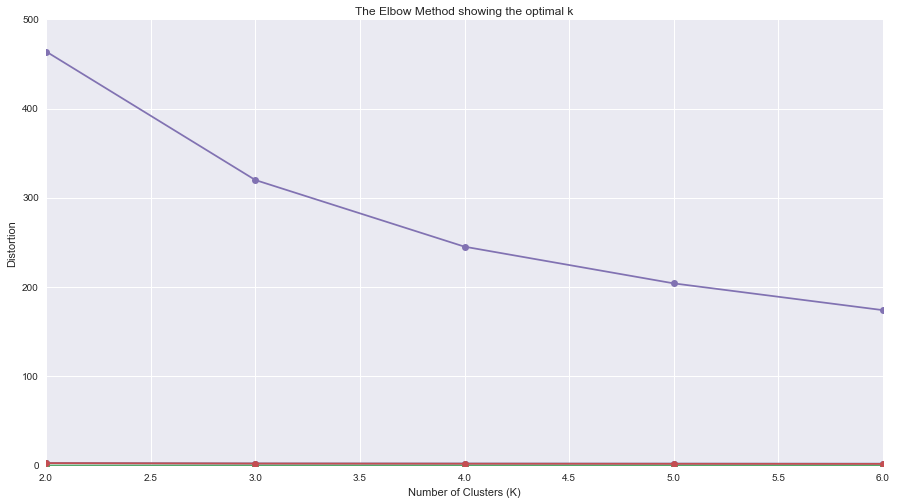

In [299]:
# Plot the elbow
plt.figure(figsize = (15,8))
plt.plot(K, distortions1, marker = 'o')
plt.plot(K, distortions2, marker = 'o')
plt.plot(K, distortions3, marker = 'o')
plt.plot(K, distortions4, marker = 'o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('Elbow_plot_exp1.png')

Optimal value remains same, K = 3

### ICA